## CIS-5200 HW-3
### 3D Reconstruction from 2 views.

### 1\. Loading images:

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import cv2
import numpy as np

image shape_left = : (410, 615, 3)
image shape_right = : (410, 615, 3)


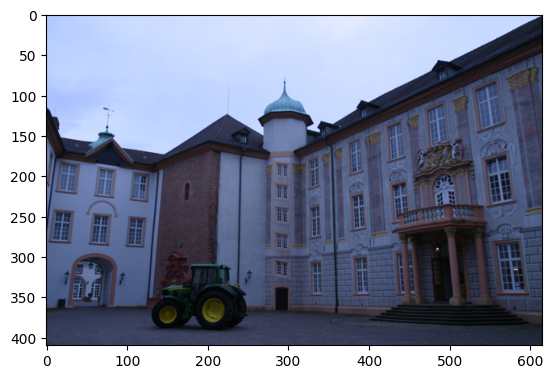

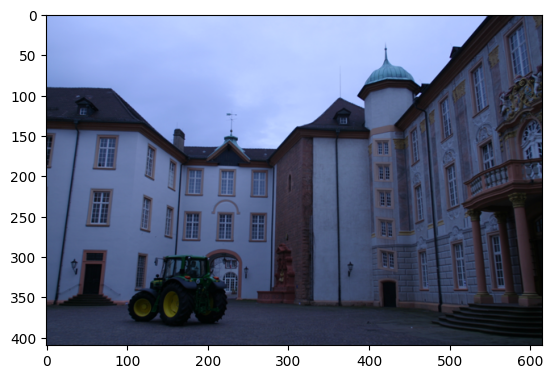

<Figure size 640x480 with 0 Axes>

In [ ]:
# load the images
im_left = cv2.imread('../data/0014_2.png')
print("image shape_left = :", im_left.shape)
plt.imshow(im_left[:, :, ::-1])
plt.figure()

im_right = cv2.imread('../data/0017_2.png')
print("image shape_right = :", im_right.shape)
plt.imshow(im_right[:, :, ::-1])
plt.figure()

images = [im_left, im_right]


### 2\. Detecting SIFT features:

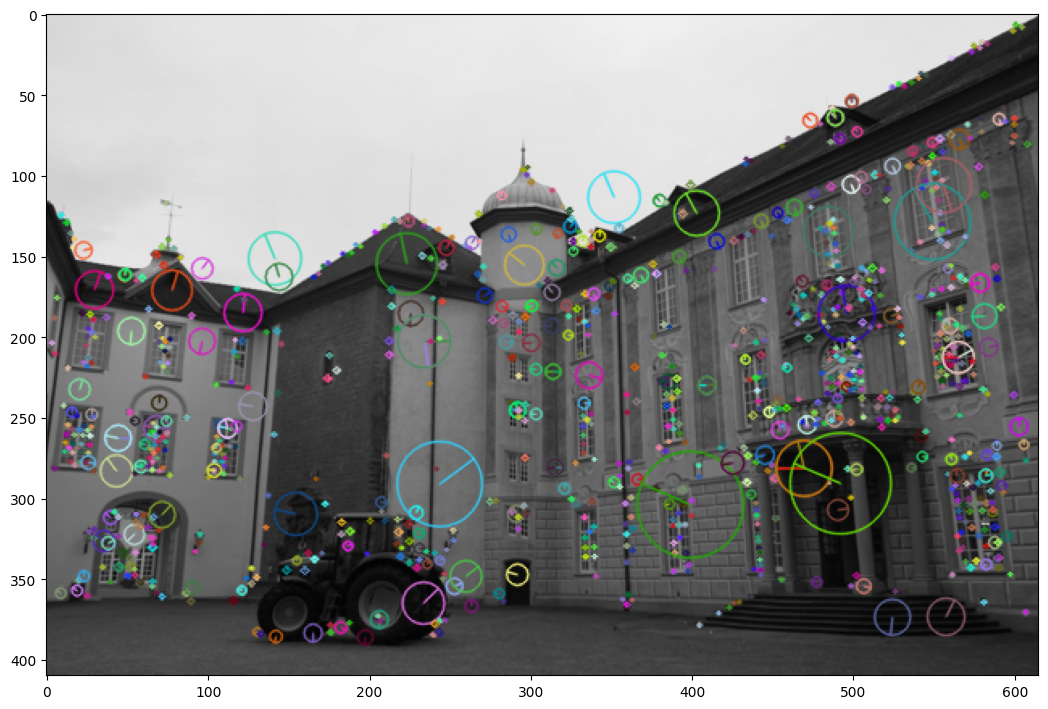

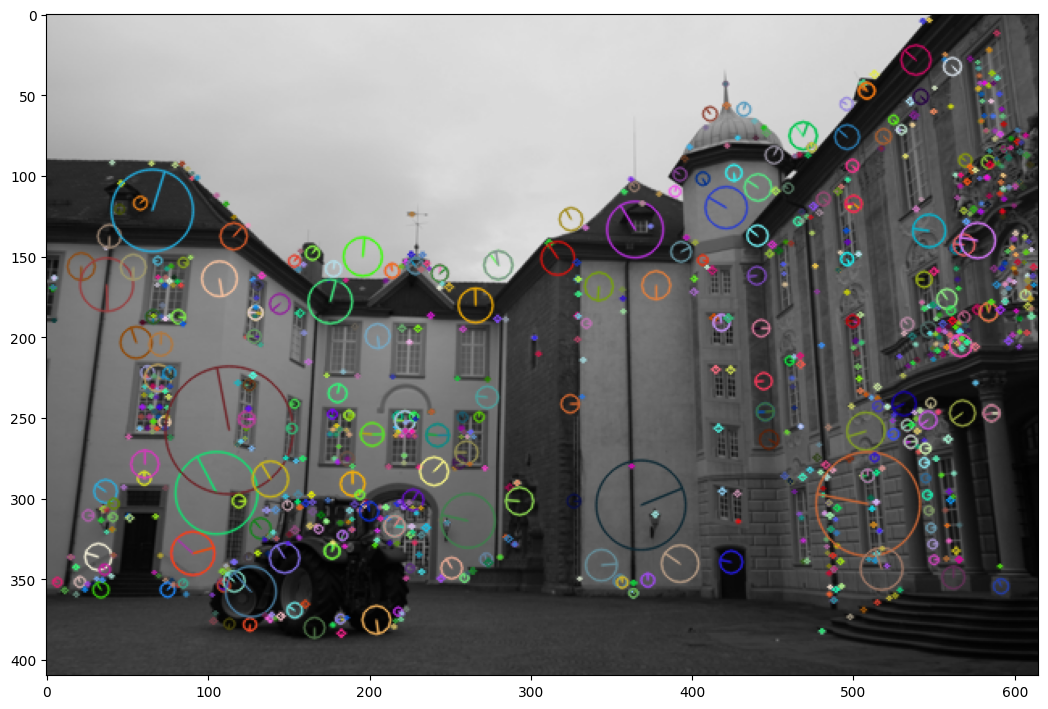

In [ ]:
""" Detects SIFT features in all of the images
"""
keypoints = [] # To store the keypoints to be matched
descriptions = [] # Descriptor Vector
for im in images:
  # Convert each image to grayscale
  gray= cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)

  sift = cv2.xfeatures2d.SIFT_create()
  # sift = cv2.SIFT_create()- Alternate way to apply SIFT

  # Detect key points in the image and compute descriptor vector:
  kp, des = sift.detectAndCompute(gray, None)
  # print(len(kp))
  # print(des.shape)

  keypoints.append(kp)
  descriptions.append(des)

  plt.figure(figsize=(6.4*2, 4.8*2))
  out_im = cv2.drawKeypoints(gray, kp, gray, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
  # out_im = cv2.drawKeypoints(gray, kp, gray)

  plt.imshow(out_im)

  sift = cv2.SIFT_create()
  # print(len(descriptions[0]))
  # print(len(keypoints[0]))


### 3\. Brute Force Matcher:

num matches =  393


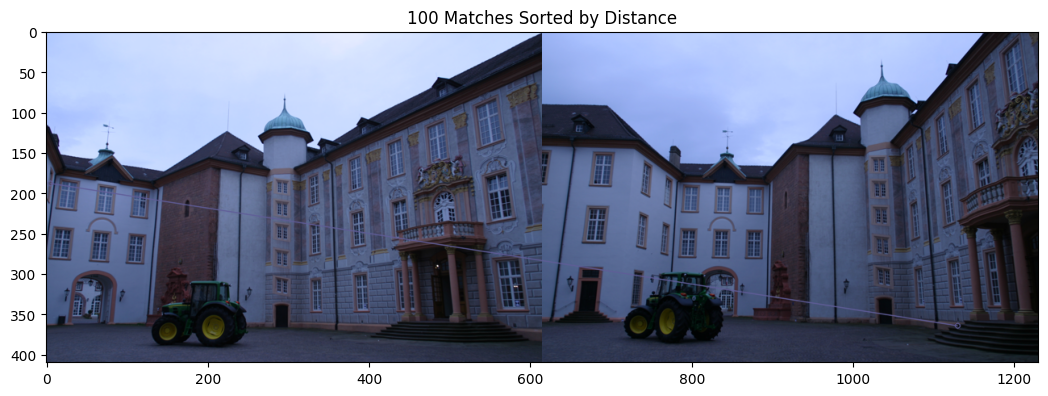

In [ ]:
""" Matches the detected keypoints between the images
"""

bf = cv2.BFMatcher(crossCheck=True) # Brute Force Matcher!
matches = bf.match(descriptions[0], descriptions[1])
# print(matches[:2])

print("num matches = ", len(matches))

# matches = sorted(matches, key = lambda x:x.distance)
matched_image = cv2.drawMatches(images[0][:, :, ::-1], keypoints[0], images[1][:, :, ::-1], keypoints[1], matches[:1], None, flags=2)
plt.figure(figsize=(6.4*2, 4.8*2))
plt.title("100 Matches Sorted by Distance")
plt.imshow(matched_image)


### 4\. Compute Calibrate:

In [ ]:
""" Compute calibrated coordinates
"""

# For the satsok castle images
f1 = f2 = 552
u0 = 307.5
v0 = 205

K = np.array([[f1, 0, u0],
              [0, f2, v0],
              [0, 0, 1]])


uncalibrated_1 = [[keypoints[0][match.queryIdx].pt[0], keypoints[0][match.queryIdx].pt[1], 1] for match in matches]
uncalibrated_2 = [[keypoints[1][match.trainIdx].pt[0], keypoints[1][match.trainIdx].pt[1], 1] for match in matches]

uncalibrated_1 = np.array(uncalibrated_1).T
uncalibrated_2 = np.array(uncalibrated_2).T

k_inv = np.linalg.inv(K)

calibrated_1 = np.matmul(k_inv, uncalibrated_1).T
calibrated_2 = np.matmul(k_inv, uncalibrated_2).T


In [ ]:
# import numpy as np
# This code was to check if the code for E was correct.
# def least_squares_estimation(X1, X2):
#   """ YOUR CODE HERE
#   """
#   A = np.zeros((X1.shape[0], 9))
#   for i in range(X1.shape[0]):
#     a2 = X2[i, :].reshape(1, 3)
#     a1 = X1[i, :].reshape(1, 3)
#     a = np.matmul(a2.T, a1)
#     a = a.reshape(1, 9)
#     A[i, :] = a
  
#   U, S, Vt = np.linalg.svd(A, full_matrices=True)
#   E1 = Vt[8, :].reshape(3, 3)
#   u, s, vt = np.linalg.svd(E1, full_matrices=True)
#   eye = np.eye(E1.shape[0])
#   eye[2, 2] = 0
#   E = u @ eye @ vt

#   """ END YOUR CODE
#   """
#   return E

In [ ]:
from lse import least_squares_estimation

E_least = least_squares_estimation(calibrated_1, calibrated_2)
print("E least", E_least)

E least [[ 0.03483464  0.19532636  0.00230723]
 [ 0.12138734  0.96929545 -0.08251168]
 [-0.48165932 -0.00994682 -0.8760465 ]]


In [ ]:
# from lse import least_squares_estimation
# import numpy as np

# def ransac_estimator(X1, X2, num_iterations=5):
#     sample_size = 8

#     eps = 10**-4

#     best_inliers = None
#     best_E = None
#     i_s = np.array([])
#     best_num_inliers = -1

#     for i in range(num_iterations):
#         permuted_indices = np.random.RandomState(seed=(i*10)).permutation(np.arange(X1.shape[0]))
#         sample_indices = permuted_indices[:sample_size]
#         test_indices = permuted_indices[sample_size:]

#         """ YOUR CODE HERE
#         """
#         E = least_squares_estimation(X1[sample_indices, :], X2[sample_indices, :])

#         for j in range(test_indices.shape[0]):
#             d1 = ((X1[test_indices[j], :] @ E.T @ X2[test_indices[j], :]).item() ** 2) \
#                 / (np.sqrt((E.T @ X2[test_indices[j], :])[0] ** 2 + \
#                           (E.T @ X2[test_indices[j], :])[1] ** 2))
            
#             d2 = ((X2[test_indices[j], :] @ E @ X1[test_indices[j], :]).item() ** 2) \
#                 / (np.sqrt((E @ X1[test_indices[j], :])[0] ** 2 + \
#                           (E @ X1[test_indices[j], :])[1] ** 2))
#             e = d1 + d2

#             if e < eps:
#                 inlier = X1[test_indices[j], :]
#                 i_s = np.append(i_s, inlier)
#                 print(i_s.shape)
        
#         inliers = i_s.reshape(int(len(i_s)/3), 3)
            

#         """ END YOUR CODE
#         # """
#         if inliers.shape[0] > best_num_inliers:
#             best_num_inliers = inliers.shape[0]
#             best_E = E
#             best_inliers = inliers
            
#     return best_E, best_inliers

E_ransac [[-0.00240025 -0.07852295  0.02252064]
 [ 0.52963389  0.01934081 -0.84772158]
 [-0.11732375  0.98877012 -0.0487032 ]]
Num inliers 194


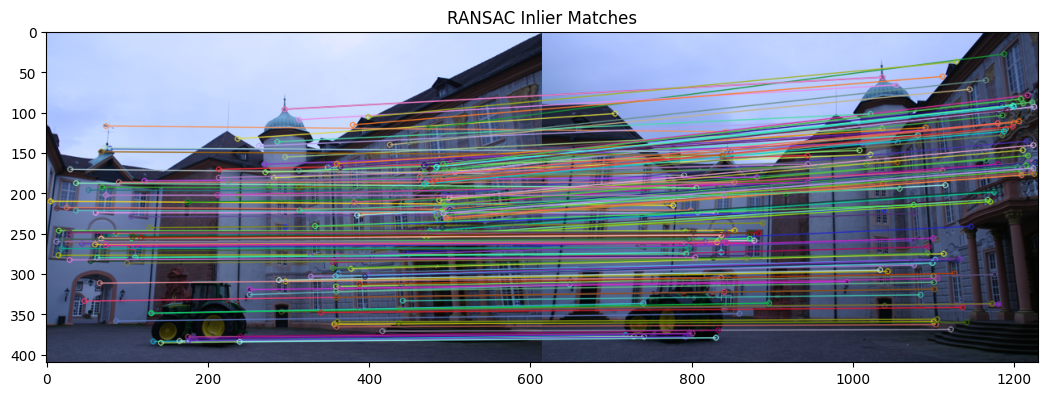

In [ ]:
from ransac import ransac_estimator

# running this cell will take a while!!!

E_ransac, inliers = ransac_estimator(calibrated_1, calibrated_2)
print("E_ransac", E_ransac)
print("Num inliers", len(inliers))
inlier_matches = [matches[i] for i in inliers]

matched_image = cv2.drawMatches(images[0][:, :, ::-1],
                                keypoints[0],
                                images[1][:, :, ::-1],
                                keypoints[1],
                                inlier_matches, None, flags=2)
plt.figure(figsize=(6.4*2, 4.8*2))
plt.title("RANSAC Inlier Matches")
plt.imshow(matched_image)

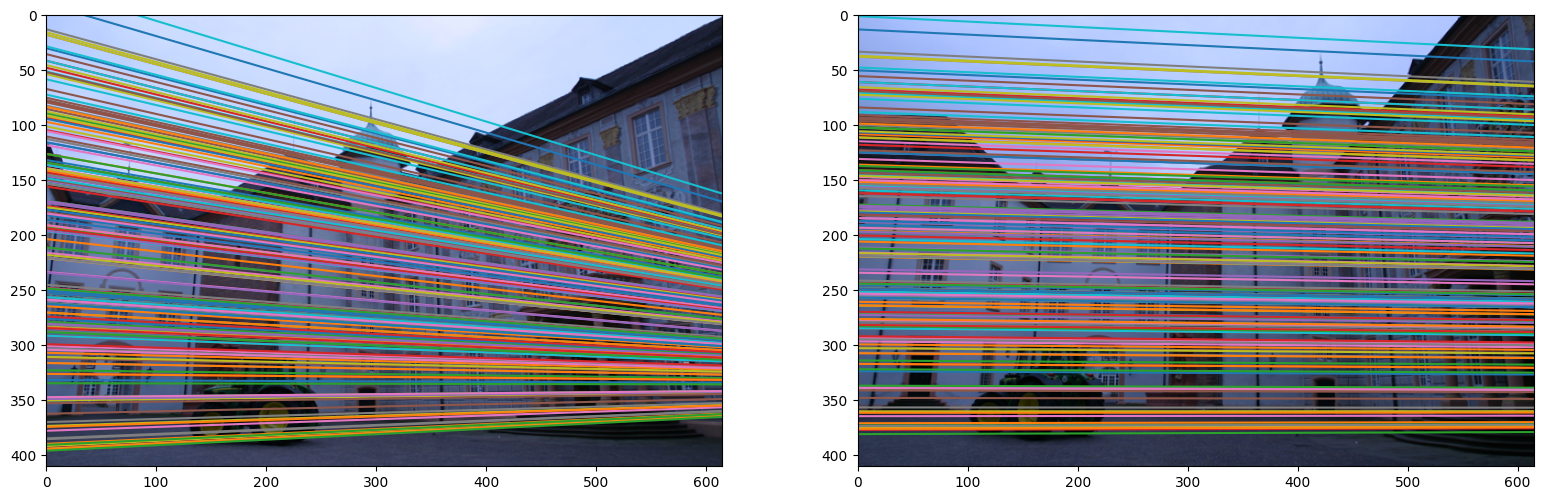

In [ ]:
from plot_epi import plot_epipolar_lines

uncalibrated_inliers_1 = [[keypoints[0][match.queryIdx].pt[0], keypoints[0][match.queryIdx].pt[1], 1] for match in inlier_matches]
uncalibrated_inliers_2 = [[keypoints[1][match.trainIdx].pt[0], keypoints[1][match.trainIdx].pt[1], 1] for match in inlier_matches]
uncalibrated_inliers_1 = np.array(uncalibrated_inliers_1).T
uncalibrated_inliers_2 = np.array(uncalibrated_inliers_2).T
plot_epipolar_lines(images[0], images[1], uncalibrated_inliers_1, uncalibrated_inliers_2, E_ransac, K)

In [ ]:
from pose import pose_candidates_from_E

transform_candidates = pose_candidates_from_E(E_ransac)
print("transform_candidates", transform_candidates)
for c in transform_candidates:
  print(np.linalg.det(c['R']))

np.array([[0, -1, 0], [1, 0, 0], [0, 0, 1]]).T

transform_candidates [{'T': array([0.99665501, 0.02195462, 0.07871969]), 'R': array([[-0.88152822, -0.10506717, -0.46029218],
       [ 0.09829894, -0.9944031 ,  0.03872721],
       [ 0.46178493,  0.01110711, -0.88692238]])}, {'T': array([0.99665501, 0.02195462, 0.07871969]), 'R': array([[-0.79299139, -0.14543831, -0.59161842],
       [-0.13518577,  0.98888489, -0.06189902],
       [-0.594045  , -0.03089301,  0.80383839]])}, {'T': array([-0.99665501, -0.02195462, -0.07871969]), 'R': array([[-0.88152822, -0.10506717, -0.46029218],
       [ 0.09829894, -0.9944031 ,  0.03872721],
       [ 0.46178493,  0.01110711, -0.88692238]])}, {'T': array([-0.99665501, -0.02195462, -0.07871969]), 'R': array([[-0.79299139, -0.14543831, -0.59161842],
       [-0.13518577,  0.98888489, -0.06189902],
       [-0.594045  , -0.03089301,  0.80383839]])}]
-1.0
-0.9999999999999998
-1.0
-0.9999999999999998


array([[ 0,  1,  0],
       [-1,  0,  0],
       [ 0,  0,  1]])

In [ ]:
def plot_reconstruction(P1, P2, T, R):
  P1trans = (R @ P1.T).T + T

  plt.figure(figsize=(6.4*2, 4.8*2))
  ax = plt.axes()
  ax.set_xlabel('x')
  ax.set_ylabel('z')

  for i in range(P1.shape[0]):
    plt.plot([0, P2[i, 0]], [0, P2[i, 2]], 'bs-')
    plt.plot([T[0], P1trans[i, 0]], [T[2], P1trans[i, 2]], 'ro-')
  plt.plot([0], [0], 'bs')
  plt.plot([T[0]], [T[2]], 'ro')

best 1 (393,)
best 352 (393,)
not best 0
not best 40
(393, 3)
(393, 3)


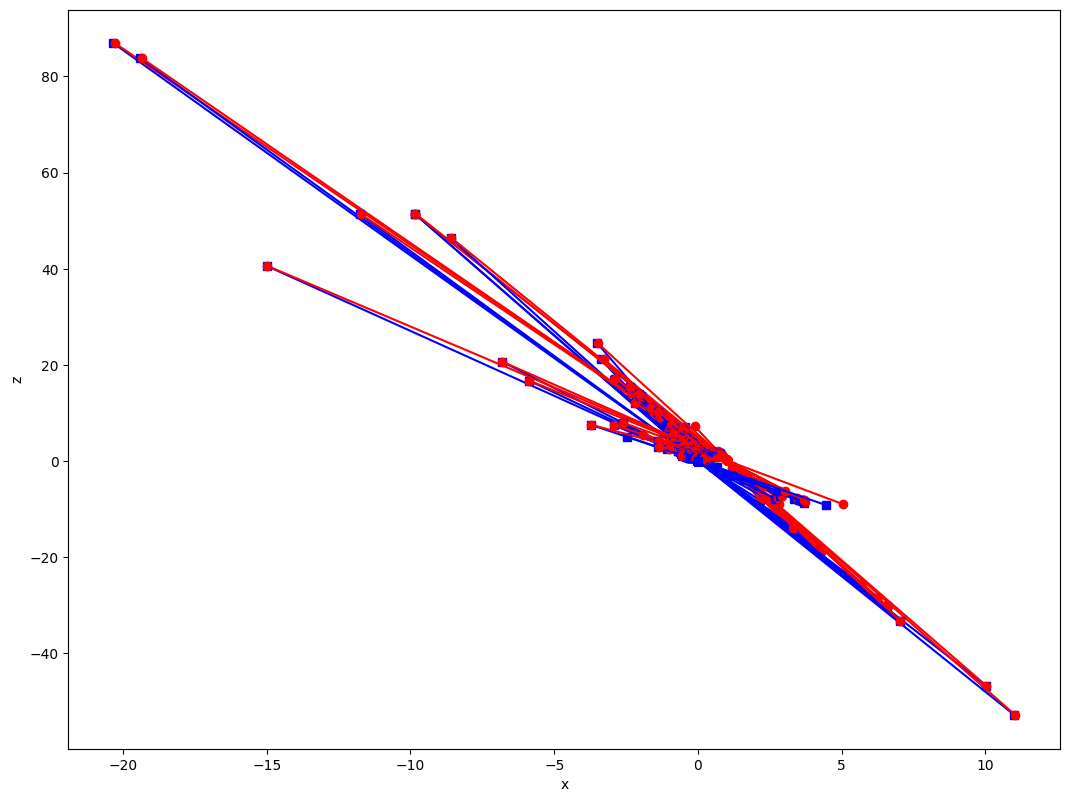

In [ ]:
from recon3d import reconstruct3D 

P1, P2, T, R = reconstruct3D(transform_candidates, calibrated_1, calibrated_2)

plot_reconstruction(P1, P2, T, R)
print(P1.shape)
print(P2.shape)

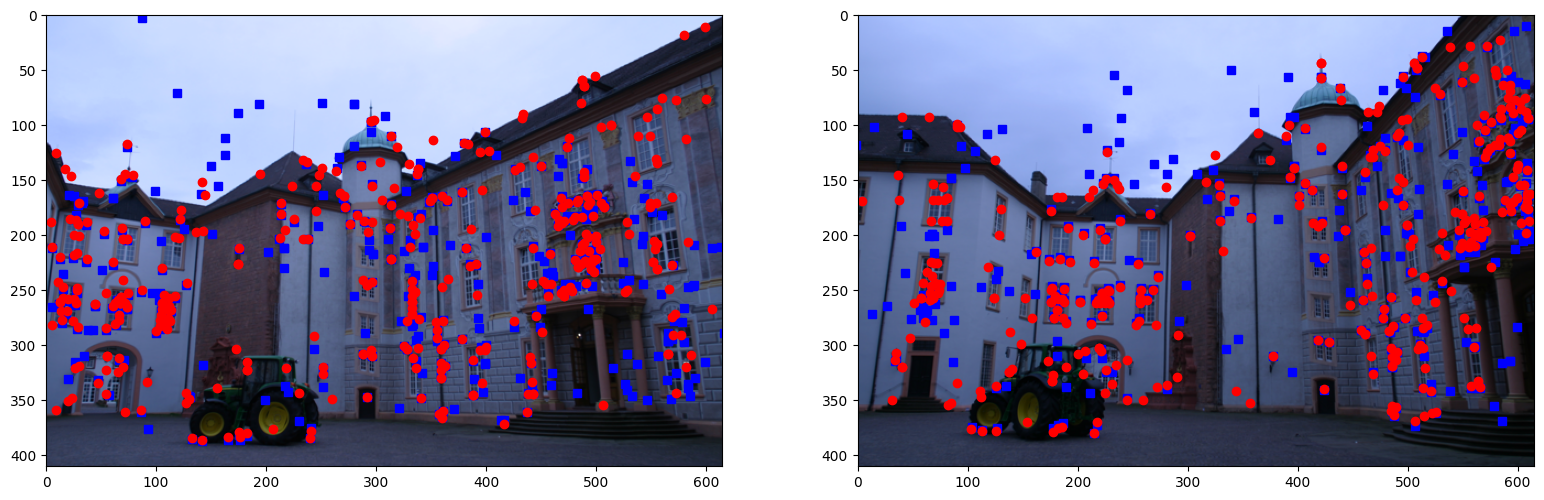

In [ ]:
from show_reproj import show_reprojections

show_reprojections(images[0], images[1], uncalibrated_1, uncalibrated_2, P1, P2, K, T, R)

In [ ]:
"""
  ---------------
  | END of CODE |
  ---------------
      """